In [1]:
pip install imblearn

     |████████████████████████████████| 199 kB 24.8 MB/s            
     |████████████████████████████████| 189 kB 55.6 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [37]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve

# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-445-wagner'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key = "train.csv"

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [38]:
# Defining the file to be read from s3 bucket
file_key1 = "test.csv"

bucket_object1 = bucket.Object(file_key1)
file_object1 = bucket_object1.get()
file_content_stream1 = file_object1.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream1, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [39]:
#reporting number of observations
test.shape

(498121, 9)

In [40]:
#reporting number of observartions
train.shape

(1879, 10)

In [41]:
#frequency table for fraud
train['fraud'].value_counts()

0    1775
1     104
Name: fraud, dtype: int64

In [50]:
#defining variables
X = train[['trustLevel','totalScanTimeInSeconds', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond']]
Y = train['fraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, stratify = Y)

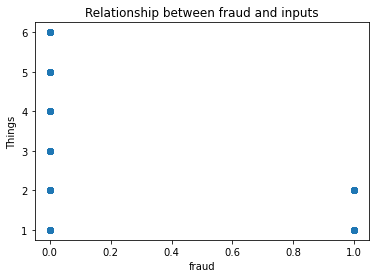

In [43]:
#creating scatter chart (first visual) for visualzation of fraud within trustlevels
plt.scatter('fraud','trustLevel', data = train)
plt.title('Relationship between fraud and inputs')
plt.xlabel('fraud')
plt.ylabel('Things')
plt.show()

In [ ]:
#We see that the only trust levels that commit fraud are the bottom two levels but we don't know how much yet

In [44]:
#creating frequency table(second visual) with fraud and trust level to see how much fraud is commited in each trust level
pd.crosstab(index=train['trustLevel'], columns=train['fraud'])

fraud,0,1
trustLevel,,
1,243,89
2,332,15
3,318,0
4,289,0
5,302,0
6,291,0


In [ ]:
#we see that the 1 trust level leads the number of frauds 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       355
           1       0.73      0.76      0.74        21

    accuracy                           0.97       376
   macro avg       0.86      0.87      0.86       376
weighted avg       0.97      0.97      0.97       376

     Recall  Precision    Cutoff
0  0.761905   0.727273  0.314321


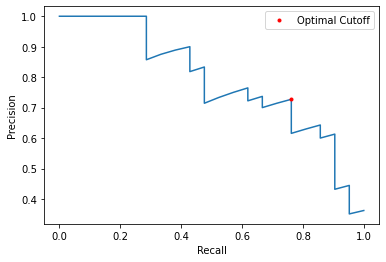

In [56]:
## Building the Random Forrest model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train, Y_train)
    
## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Computing the precision-recall curve to estimate the optimal cut-off value
precision, recall, cutoff = precision_recall_curve(Y_test, rf_preds)

# Creating data frame
rf_cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': cutoff})

# Finding optimal cutoffs
rf_cutoff['Recall_minus_1'] = rf_cutoff['Recall'] - 1
rf_cutoff['Precision_minus_1'] = rf_cutoff['Precision'] - 1
rf_cutoff['Distance'] = np.sqrt(rf_cutoff['Recall_minus_1']**2 + rf_cutoff['Precision_minus_1']**2)

# Sorting the data frame and finding optimal cutoff
rf_cutoff = rf_cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)
rf_cutoff_val = rf_cutoff['Cutoff'][0]

# Changing likelihoods labels with new cutoff value
rf = np.where(rf_preds < rf_cutoff_val, 0, 1)

# Printing classification report and optimal cutoff
print(classification_report(Y_test, rf))

print(rf_cutoff[['Recall', 'Precision', 'Cutoff']][0:1])

#Plotting Curve
Fraud = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot(recall, precision)
#Marking optimal cutoff
plt.plot([rf_cutoff['Recall'][0]], rf_cutoff['Precision'][0], '.', color = 'Red', label = 'Optimal Cutoff')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       355
           1       0.76      0.90      0.83        21

    accuracy                           0.98       376
   macro avg       0.88      0.94      0.91       376
weighted avg       0.98      0.98      0.98       376

     Recall  Precision    Cutoff
0  0.904762       0.76  0.094364


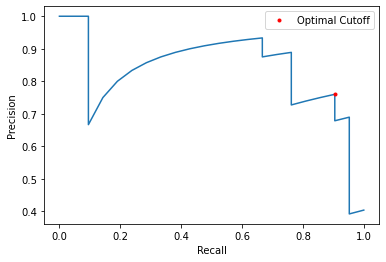

In [59]:
## Building the Adabooster Model model
ad_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500, learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on the test set
ad_preds = ad_md.predict_proba(X_test)[:, 1]

## Computing the precision-recall curve to estimate the optimal cut-off value
precision, recall, cutoff = precision_recall_curve(Y_test, ad_preds)

# Creating data frame
ad_cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': cutoff})

# Finding optimal cutoffs
ad_cutoff['Recall_minus_1'] = ad_cutoff['Recall'] - 1
ad_cutoff['Precision_minus_1'] = ad_cutoff['Precision'] - 1
ad_cutoff['Distance'] = np.sqrt(ad_cutoff['Recall_minus_1']**2 + ad_cutoff['Precision_minus_1']**2)

# Sorting the data frame and finding best cutoff
ad_cutoff = ad_cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)
ad_cutoff_val = ad_cutoff['Cutoff'][0]

# Changing likelihoods labels with new cutoff value
ad = np.where(ad_preds < ad_cutoff_val, 0, 1)

# Printing classification report and optimal cutoff
print(classification_report(Y_test, ad))
print(ad_cutoff[['Recall', 'Precision', 'Cutoff']][0:1])

#Plotting Curve
Fraud = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot(recall, precision)
#Marking optimal cutoff
plt.plot([ad_cutoff['Recall'][0]], ad_cutoff['Precision'][0], '.', color = 'Red', label = 'Optimal Cutoff')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# based off of the two above models I would use the second model (the AdaBooster model) because it has a higher overall
#recall and precision